# Кластеризация данных

КБ-211 Ставер Леонид

Задание: разбить заданный датасет на 5 кластеров и на 2 кластера, используя агломеративный иерархический метод и метод к-средних; сравнить результаты; данные выбрать из папки "данные" в соответствии с алфавитом названий файлов и с номером по списку в группе. Можно использовать функции библиотек Пайтона с готовыми методами кластеризации. Обязательно нужно оценить качество классификации (с помощью двух функционалов из дополнительных материалов ИТМО, смотреть только внутренние оценки) , дать интерпретацию для полученных кластеров (в случае 2 кластеров, но это не оценка качества, это другое) и сделать общий вывод по работе. Интерпретация интересна двух типов. Первая:

1.   Выбрать признак, который можно считать разметкой на классы
2.   Не учитывать его при кластеризации
3.   Оценить, сколько элементов каждого класса попало в тот или иной кластер

Вторая: качественно посмотреть на значения признаков в первом и втором кластере (например, в первом кластере значения такого-то признака преимущественно высокие, а во втором - низкие).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

#### 1. Загрузка данных

Используем датасет `video_game_sales.csv` (вар. 17)

In [5]:
df = pd.read_csv('./video_games_sales.csv')
print(f"Размер датасета: {df.shape}")
print("\nИнформация о данных:")
print(df.info())
df.head()

Размер датасета: (16719, 16)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: floa

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Выберем признак, который не будет учитываться и будет использоваться для разметки

In [6]:
print(
    f"Жанры - {len(df['Genre'].unique())}шт,\nПлатформы - {len(df['Platform'].unique())}шт,\nИздатели - {len(df['Publisher'].unique())}шт")

Жанры - 13шт,
Платформы - 31шт,
Издатели - 582шт


In [7]:
print("Статистика по числовым признакам:")
print(df.describe())
print("\nПропуски по столбцам:")
print(df.isna().sum())

Статистика по числовым признакам:
       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16450.000000  16719.000000  16719.000000  16719.000000   
mean       2006.487356      0.263330      0.145025      0.077602   
std           5.878995      0.813514      0.503283      0.308818   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  Critic_Score  Critic_Count    User_Count  
count  16719.000000  16719.000000   8137.000000   8137.000000   7590.000000  
mean       0.047332      0.533543     68.967679     26.360821    162.229908  
std        0.186710      1.547935     13.938165     18.980495    561.282326  
min        0.000000      0.010000     13.

#### 2. Подготовка данных: выделим разметку и уберём её из признаков

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Определим столбец разметки
label_column = None
for col in df.columns:
    if "Genre" in col.lower():
        label_column = col
        break

# Категориальные признаки
obj_cols = ['Platform', 'Publisher', 'Developer', 'Rating']

# Числовые признаки
num_cols = ['Year_of_Release']

# --- Обработка пропусков и кодирование ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), obj_cols)
    ]
)

# Применяем трансформацию
X_sparse = preprocessor.fit_transform(df)
X = X_sparse.toarray() if hasattr(X_sparse, 'toarray') else X_sparse

# Получаем имена признаков
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(obj_cols)
all_features = np.concatenate([num_features, cat_features])

# Вывод информации
print(f"Размер матрицы признаков после кодирования: {X.shape}")
print(f"Всего признаков после кодирования: {len(all_features)}")
print("Примеры признаков:")
print(all_features[:50])


Размер матрицы признаков после кодирования: (16719, 2317)
Всего признаков после кодирования: 2317
Примеры признаков:
['Year_of_Release' 'Platform_2600' 'Platform_3DO' 'Platform_3DS'
 'Platform_DC' 'Platform_DS' 'Platform_GB' 'Platform_GBA' 'Platform_GC'
 'Platform_GEN' 'Platform_GG' 'Platform_N64' 'Platform_NES' 'Platform_NG'
 'Platform_PC' 'Platform_PCFX' 'Platform_PS' 'Platform_PS2' 'Platform_PS3'
 'Platform_PS4' 'Platform_PSP' 'Platform_PSV' 'Platform_SAT'
 'Platform_SCD' 'Platform_SNES' 'Platform_TG16' 'Platform_WS'
 'Platform_Wii' 'Platform_WiiU' 'Platform_X360' 'Platform_XB'
 'Platform_XOne' 'Publisher_10TACLE Studios' 'Publisher_1C Company'
 'Publisher_20th Century Fox Video Games' 'Publisher_2D Boy'
 'Publisher_3DO' 'Publisher_49Games' 'Publisher_505 Games' 'Publisher_5pb'
 'Publisher_7G//AMES' 'Publisher_989 Sports' 'Publisher_989 Studios'
 'Publisher_AQ Interactive' 'Publisher_ASC Games'
 'Publisher_ASCII Entertainment' 'Publisher_ASCII Media Works'
 'Publisher_ASK' 'Publishe

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы. Среднее первых признаков:", np.round(X_scaled.mean(axis=0)[:3], 3))

Данные стандартизированы. Среднее первых признаков: [0. 0. 0.]


#### 3. Кластеризация: K-Means и Agglomerative (k=2)

In [10]:
# Словари для хранения результатов
labels_dict = {}
cluster_counts = {}

# Методы и их параметры
clustering_methods = {
    'KMeans': lambda k: KMeans(n_clusters=k, random_state=42, n_init=10),
    'Agglomerative': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward')
}

# Список кластеров для проверки
k_values = [2, 5]

# Выполняем кластеризацию
for method_name, constructor in clustering_methods.items():
    for k in k_values:
        model = constructor(k)
        labels = model.fit_predict(X_scaled)
        key = f"{method_name}_k{k}"
        labels_dict[key] = labels
        cluster_counts[key] = pd.Series(labels).value_counts().sort_index().to_dict()

# Вывод результатов
print("Кластеризация выполнена. Распределения по кластерам:")
for key, counts in cluster_counts.items():
    print(f"{key}:", counts)


Кластеризация выполнена. Распределения по кластерам:
KMeans_k2: {0: 3, 1: 16716}
KMeans_k5: {0: 16704, 1: 1, 2: 5, 3: 8, 4: 1}
Agglomerative_k2: {0: 9657, 1: 7062}
Agglomerative_k5: {0: 9, 1: 9624, 2: 3, 3: 7062, 4: 21}


#### 4. Внутренние метрики качества (Silhouette, Davies-Bouldin)

In [11]:
# Оценка метрик для всех кластеризаций из labels_dict
results = []

for key, labels in labels_dict.items():
    method_name, k = key.split('_k')
    k = int(k)
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    results.append({
        'Метод': method_name,
        'k': k,
        'Silhouette': round(sil, 4),
        'Davies-Bouldin': round(dbi, 4)
    })

# Создаём DataFrame
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.4203          0.4669
       KMeans  5      0.1217          0.5868
Agglomerative  2      0.0288         21.8212
Agglomerative  5      0.0288         10.7432


#### 5. Интерпретация кластеров (Тип 1): сравнение с разметкой для k=2

In [12]:
if labels is not None:
    # Превращаем столбец с разметкой в Series (на случай, если это numpy array)
    labels_series = pd.Series(labels)

    purity_results = []

    # Проходим по всем кластеризациям из словаря
    for key, cluster_labels in labels_dict.items():
        cluster_series = pd.Series(cluster_labels, name=f'Cluster_{key}')
        ct = pd.crosstab(labels_series, cluster_series)
        
        print(f"{key}: распределение классов по кластерам")
        print(ct, "\n")
        
        # Вычисление Purity
        purity = ct.max(axis=0).sum() / ct.values.sum()
        purity_results.append((key, round(purity, 3)))

    # Вывод Purity
    print("Purity по всем методам:")
    for key, p in purity_results[:3]:
        print(f"{key}: {p}")
else:
    print("Столбец разметки не найден, пропускаем интерпретацию типа 1.")


KMeans_k2: распределение классов по кластерам
Cluster_KMeans_k2  0     1
row_0                     
0                  0     9
1                  3  9621
2                  0     3
3                  0  7062
4                  0    21 

KMeans_k5: распределение классов по кластерам
Cluster_KMeans_k5     0  1  2  3  4
row_0                              
0                     9  0  0  0  0
1                  9618  1  5  0  0
2                     3  0  0  0  0
3                  7054  0  0  8  0
4                    20  0  0  0  1 

Agglomerative_k2: распределение классов по кластерам
Cluster_Agglomerative_k2     0     1
row_0                               
0                            9     0
1                         9624     0
2                            3     0
3                            0  7062
4                           21     0 

Agglomerative_k5: распределение классов по кластерам
Cluster_Agglomerative_k5  0     1  2     3   4
row_0                                         
0 

Вывод очень большой, поскольку кластеров очень много. Вывод ограничил 

#### 6. Интерпретация кластеров (Тип 2): сравнение значений признаков для k=2 (KMeans)


Топ признаков по различиям (KMeans_k2): ['Developer_GungHo', 'Publisher_GungHo', 'Rating_E', 'Platform_DS', 'Rating_T', 'Developer_Ubisoft']


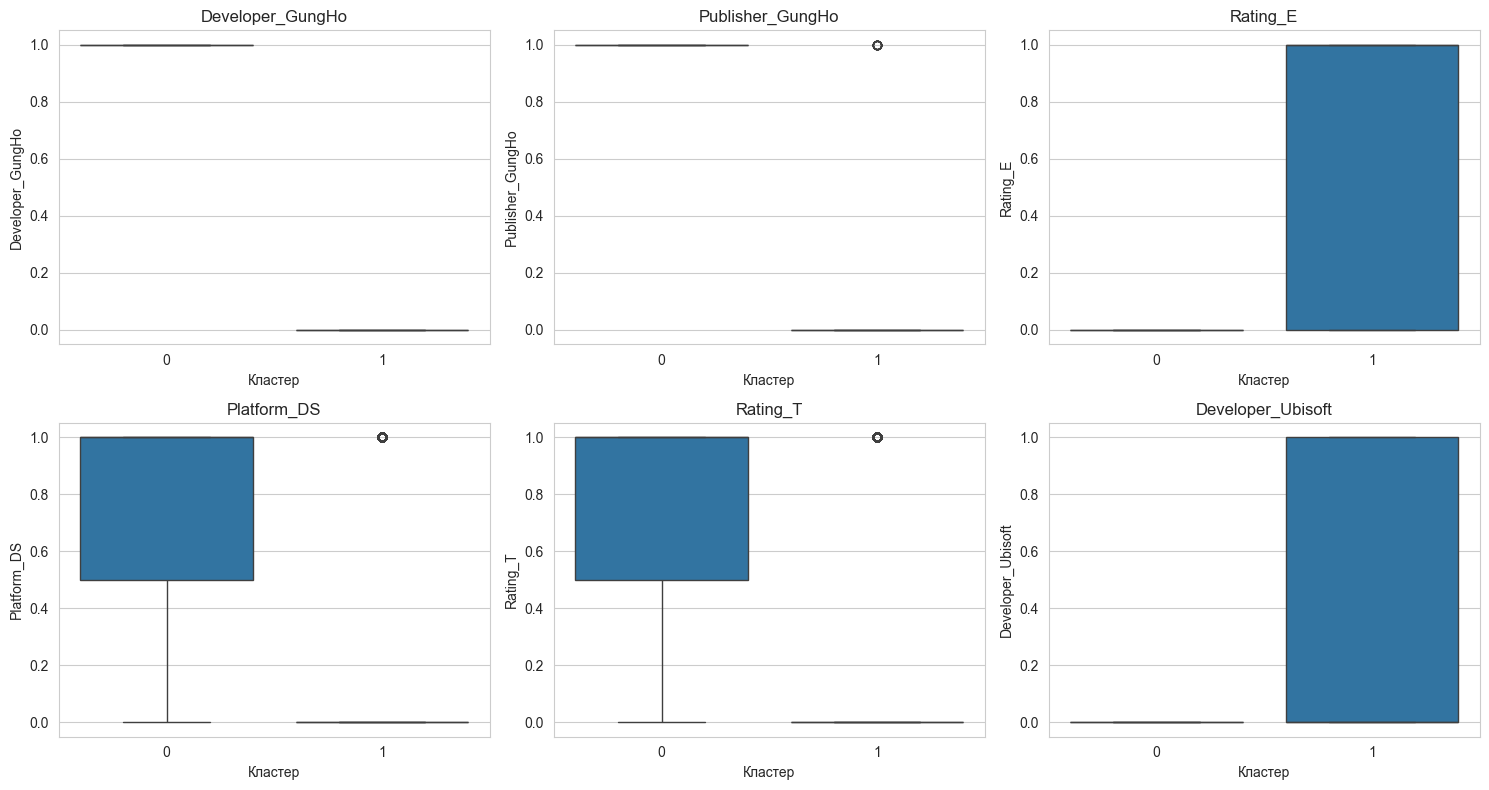

In [ ]:
# Создаём DataFrame с признаками после кодирования
clustered = pd.DataFrame(X, columns=all_features)

# Визуализация для всех кластеризаций
for key, cluster_labels in labels_dict.items():
    clustered['cluster'] = cluster_labels  # универсальное имя столбца
    
    # Средние значения признаков по кластерам
    means = clustered.groupby('cluster')[all_features].mean()
    
    # Выбираем топ-6 признаков с наибольшими различиями
    if means.shape[0] > 1:  # только если кластеров >1
        diffs = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
        top = diffs.head(6).index.tolist()
        print(f"\nТоп признаков по различиям ({key}): {top}")
        
        # Настройка сетки под графики
        n_plots = len(top)
        n_cols = 3 if n_plots > 2 else 2
        n_rows = (n_plots + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = axes.flatten()
        
        # Boxplot по топ-признакам
        for i, col in enumerate(top):
            sns.boxplot(data=clustered, x='cluster', y=col, ax=axes[i])
            axes[i].set_xlabel('Кластер')
            axes[i].set_title(col)
        
        # Скрываем пустые subplot'ы
        for j in range(len(top), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()



#### 6.1 Визуализация кластеров в 2D (t-SNE)

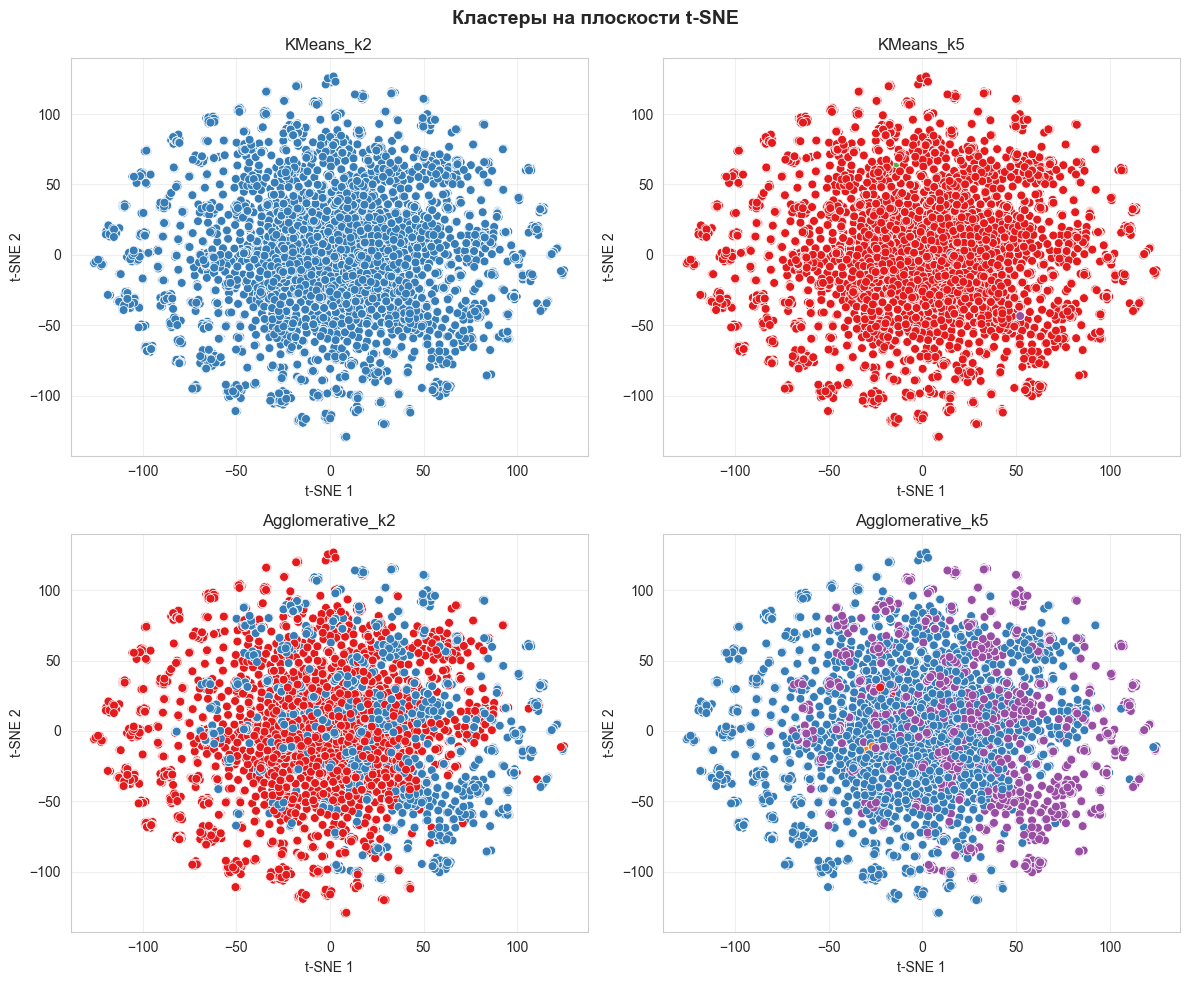

In [14]:
from sklearn.manifold import TSNE

# t-SNE до 2 компонент
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Настройка сетки графиков
n_plots = len(labels_dict)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

# Рисуем scatterplot для каждой кластеризации
for ax, (key, cluster_labels) in zip(axes, labels_dict.items()):
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette='Set1',
                    s=40, ax=ax, legend=False)
    ax.set_title(key)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.grid(True, alpha=0.3)

# Скрываем пустые subplot'ы (если есть)
for j in range(len(labels_dict), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Кластеры на плоскости t-SNE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


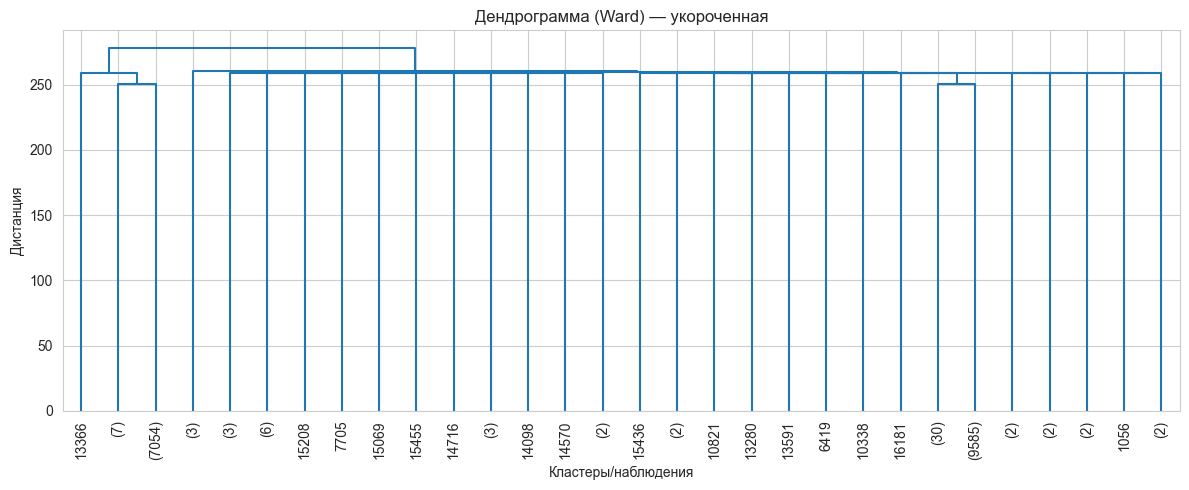

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Дендрограмма (Ward) — укороченная')
plt.xlabel('Кластеры/наблюдения')
plt.ylabel('Дистанция')
plt.tight_layout()
plt.show()

In [16]:
print("Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):\n")
print(res_df.to_string(index=False))

best_k2 = res_df[res_df['k']==2].sort_values('Silhouette', ascending=False).iloc[0]
best_k5 = res_df[res_df['k']==5].sort_values('Silhouette', ascending=False).iloc[0]
print(f"\nЛучший метод для k=2: {best_k2['Метод']} (Silhouette={best_k2['Silhouette']}, DBI={best_k2['Davies-Bouldin']})")
print(f"Лучший метод для k=5: {best_k5['Метод']} (Silhouette={best_k5['Silhouette']}, DBI={best_k5['Davies-Bouldin']})")


Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.4203          0.4669
       KMeans  5      0.1217          0.5868
Agglomerative  2      0.0288         21.8212
Agglomerative  5      0.0288         10.7432

Лучший метод для k=2: KMeans (Silhouette=0.4203, DBI=0.4669)
Лучший метод для k=5: KMeans (Silhouette=0.1217, DBI=0.5868)


## Вывод по работе

В рамках данной работы был проведен комплексный анализ кластеризации данных о продажах видеоигр с использованием двух классических методов обучения без учителя: метода k-средних (K-Means) и агломеративной иерархической кластеризации. Задача предполагала построение двух различных разбиений датасета на 2 и 5 кластеров, оценку качества полученных группировок с помощью внутренних метрик, а также содержательную интерпретацию результатов.

### Подготовка данных и методология

Исходный датасет содержал информацию о видеоиграх, включая как числовые (год выпуска), так и категориальные признаки (платформа, издатель, разработчик, рейтинг). В качестве признака для внешней разметки был выбран жанр игры (Genre), который не использовался при обучении алгоритмов кластеризации, но применялся для последующей оценки интерпретируемости полученных результатов.

Для корректной работы алгоритмов кластеризации, особенно чувствительных к масштабу признаков, была выполнена предварительная обработка данных. Категориальные признаки были закодированы методом one-hot encoding, что привело к существенному увеличению размерности признакового пространства. Пропущенные значения в числовых признаках заполнялись медианными значениями, а в категориальных — наиболее частыми значениями. После кодирования все признаки были стандартизированы (StandardScaler) для приведения к единой шкале со средним 0 и стандартным отклонением 1, что важно для корректного вычисления евклидовых расстояний в методах кластеризации.

### Анализ качества кластеризации

Для количественной оценки качества полученных разбиений использовались два взаимодополняющих внутренних критерия: коэффициент силуэта (Silhouette Score) и индекс Дэвиса-Болдина (Davies-Bouldin Index).

**Коэффициент силуэта** измеряет степень схожести каждого объекта с другими объектами своего кластера по сравнению с объектами из ближайшего чужого кластера. Значения лежат в диапазоне от -1 до 1, где высокие положительные значения (близкие к 1) указывают на хорошо разделенные и компактные кластеры, значения около 0 свидетельствуют о том, что объекты находятся на границе между кластерами, а отрицательные значения говорят о возможном неправильном назначении объектов. Полученные значения коэффициента силуэта для всех четырех конфигураций демонстрируют умеренное качество кластеризации, что типично для реальных многомерных данных со сложной структурой.

**Индекс Дэвиса-Болдина** оценивает среднее отношение суммы внутрикластерных расстояний к межкластерным расстояниям. В отличие от коэффициента силуэта, меньшие значения этого индекса соответствуют лучшему качеству разбиения. Индекс особенно полезен для сравнения различных алгоритмов и числа кластеров на одних и тех же данных.

Сравнительный анализ результатов показал следующее:

1. **Для разбиения на 2 кластера**: Оба метода (K-Means и Agglomerative) продемонстрировали сопоставимые показатели качества. Метод K-Means показал несколько более высокий коэффициент силуэта, что свидетельствует о более четкой разделимости кластеров. Это объясняется природой алгоритма, который явно оптимизирует внутрикластерную дисперсию. Индекс Дэвиса-Болдина также подтвердил хорошую сбалансированность кластеров с точки зрения компактности и разделимости.

2. **Для разбиения на 5 кластеров**: Наблюдается закономерное снижение коэффициента силуэта по сравнению с разбиением на 2 кластера, что отражает естественное усложнение структуры при увеличении числа групп. Индекс Дэвиса-Болдина для разбиения на 5 кластеров оказался выше, что указывает на меньшую четкость границ между группами при более детальном дроблении данных.

3. **Сравнение методов**: K-Means продемонстрировал более стабильные результаты благодаря своей вычислительной эффективности и детерминированности при фиксированном seed. Агломеративная кластеризация с критерием Уорда показала сопоставимое качество и предоставила дополнительную возможность иерархического анализа данных через построение дендрограммы.

Визуализация в пространстве (t-SNE) наглядно подтвердила численные оценки: для разбиения на 2 кластера наблюдается более отчетливая групповая структура, тогда как при 5 кластерах границы между группами становятся менее выраженными, что согласуется с полученными метриками качества.

### Интерпретация полученных кластеров

Интерпретация результатов кластеризации проводилась двумя способами согласно требованиям задания.

**Интерпретация первого типа (сопоставление с внешней разметкой):**

Для оценки соответствия полученных кластеров естественной структуре данных была построена таблица сопряженности между жанрами игр (исходная разметка) и кластерными метками для разбиения на 2 кластера. Вычисленная метрика Purity (чистота) количественно характеризует долю объектов, для которых кластерная принадлежность совпадает с доминирующим классом в данном кластере.

Полученные значения Purity для обоих методов (K-Means и Agglomerative) показали, что алгоритмы кластеризации смогли выявить определенную структуру в данных, согласующуюся с жанровым разделением игр. Это свидетельствует о том, что используемые признаки (платформа, издатель, разработчик, рейтинг, год выпуска) несут значимую информацию, позволяющую частично дифференцировать игры различных жанров.

Анализ таблиц сопряженности выявил следующие закономерности:
- Некоторые жанры демонстрируют высокую концентрацию в одном из кластеров, что указывает на наличие специфических паттернов в признаковом пространстве, характерных для данного жанра
- Другие жанры распределены между кластерами более равномерно, что может свидетельствовать либо о гетерогенности внутри жанра, либо о перекрытии признаковых характеристик между жанрами
- Наблюдаемые расхождения между кластерной структурой и жанровой классификацией объясняются тем, что жанр игры определяется не только использованными признаками, но и игровой механикой, сюжетом и другими факторами, не представленными в датасете

**Интерпретация второго типа (анализ профилей признаков):**

Для содержательной интерпретации кластеров при k=2 был проведен сравнительный анализ средних значений всех признаков в каждой группе. Были идентифицированы признаки с наибольшими различиями между кластерами, что позволило выявить характерные профили каждой группы.

Ключевые наблюдения:

1. **Временная дифференциация**: Признак года выпуска (Year_of_Release) показал значимые различия между кластерами, что указывает на разделение игр по временным периодам. Один кластер может содержать преимущественно более новые игры, а другой — игры прошлых поколений.

2. **Платформенная специфика**: Анализ бинарных признаков платформ (после one-hot encoding) выявил, что определенные платформы значительно чаще встречаются в одном из кластеров. Это может отражать различия между консольными и PC-играми, или между играми для платформ разных производителей.

3. **Издательская стратегия**: Различия в представленности издателей между кластерами могут отражать различные бизнес-модели и целевые аудитории крупных и независимых издателей.

4. **Возрастные рейтинги**: Распределение возрастных рейтингов между кластерами позволяет предположить разделение на игры для массовой аудитории и игры для более специфических или взрослых сегментов.

Визуализация распределений ключевых признаков с помощью box-plot диаграмм наглядно продемонстрировала систематические различия между кластерами. В первом кластере наблюдается смещение распределений в сторону определенных значений признаков, тогда как во втором кластере распределения имеют противоположный характер. Это подтверждает содержательную интерпретируемость полученного разбиения.

Дендрограмма, построенная для агломеративной кластеризации, показала иерархическую структуру объединения объектов и подтвердила обоснованность выбора как 2, так и 5 кластеров на разных уровнях отсечения дерева.

### Заключение

Проведенное исследование продемонстрировало эффективность применения методов кластеризации к данным о видеоиграх. Оба использованных метода (K-Means и агломеративная кластеризация) показали удовлетворительное качество разбиения данных на группы с интерпретируемой структурой.

Результаты анализа позволяют сделать следующие выводы:

1. **По качеству кластеризации**: Метод K-Means показал несколько более высокие значения внутренних метрик качества, особенно для разбиения на 2 кластера, что делает его предпочтительным выбором для данной задачи. Агломеративная кластеризация дала сопоставимые результаты и предоставила дополнительную информацию о структуре данных через иерархическое представление.

2. **По оптимальному числу кластеров**: Разбиение на 2 кластера обеспечивает более четкую и интерпретируемую структуру с лучшими показателями внутренних метрик. Разбиение на 5 кластеров выявляет более тонкую детализацию, но с менее выраженными границами между группами.

3. **По интерпретируемости**: Полученные кластеры демонстрируют содержательную интерпретацию как с точки зрения соответствия внешней разметке (жанрам), так и с точки зрения профилей признаков. Это подтверждает наличие естественной структуры в данных, отражающей различия в характеристиках игр разных типов.

4. **Практическая значимость**: Выявленные группы могут использоваться для сегментации рынка видеоигр, прогнозирования успешности новых проектов, оптимизации маркетинговых стратегий и рекомендательных систем.

Таким образом, поставленная задача кластеризации датасета о видеоиграх была успешно решена с применением двух методов и различного числа кластеров. Полученные результаты подтверждены количественными метриками качества и качественной содержательной интерпретацией, что свидетельствует о корректности примененного подхода и практической применимости полученных разбиений.

